In [1]:
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

raw_data = load_files(r'E:\Programs\Human Activity Data\Data', random_state=17)
files = raw_data['filenames']
targets = raw_data['target']

train_files, test_files, train_targets, test_targets = train_test_split(files, targets, test_size=0.25, random_state=17)

In [2]:
import numpy as np
from utils import read_videos, one_hot_encode

X_train = read_videos(train_files[:200], target_size=(64, 64), max_frames=100, extract_frames='last', normalize_pixels=True)
y_train = one_hot_encode(train_targets[:200], num_classes=6)
print('Shape of training data:', X_train.shape)
print('Shape of training labels:', y_train.shape)

X_test = read_videos(test_files[:100], target_size=(64, 64), max_frames=100, extract_frames='last', normalize_pixels=True)
y_test = one_hot_encode(test_targets[:100], num_classes=6)
print('Shape of testing data:', X_test.shape)
print('Shape of testing labels:', y_test.shape)

Using TensorFlow backend.
100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:24<00:00,  2.35it/s]


Shape of training data: (200, 100, 64, 64, 1)
Shape of training labels: (200, 6)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.63it/s]


Shape of testing data: (100, 100, 64, 64, 1)
Shape of testing labels: (100, 6)


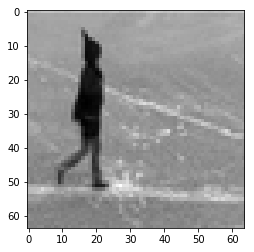

In [3]:
plt.imshow(np.squeeze(X_train[192][56], axis=2), cmap='gray')

In [4]:
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D
from keras.layers.core import Dense, Dropout

model = Sequential()

model.add(Conv3D(filters=16, kernel_size=3, strides=1, padding='same', 
                 activation='relu', kernel_initializer='he_normal', input_shape=X_train.shape[1:]))
model.add(MaxPooling3D(pool_size=2, strides=2, padding='valid'))
model.add(Conv3D(filters=32, kernel_size=3, strides=1, padding='same', 
                 activation='relu', kernel_initializer='he_normal'))
model.add(MaxPooling3D(pool_size=2, strides=2, padding='valid'))
model.add(Conv3D(filters=64, kernel_size=3, strides=1, padding='same', 
                 activation='relu', kernel_initializer='he_normal'))
model.add(MaxPooling3D(pool_size=2, strides=2, padding='valid'))
model.add(Conv3D(filters=128, kernel_size=3, strides=1, padding='same', 
                 activation='relu', kernel_initializer='he_normal'))
model.add(MaxPooling3D(pool_size=2, strides=2, padding='valid'))
model.add(GlobalAveragePooling3D())
model.add(Dropout(0.3))
model.add(Dense(6, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 100, 64, 64, 16)   448       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 50, 32, 32, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 50, 32, 32, 32)    13856     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 25, 16, 16, 32)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 25, 16, 16, 64)    55360     
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 12, 8, 8, 64)      0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 12, 8, 8, 128)     221312    
__________

In [5]:
from keras.callbacks import ModelCheckpoint

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='CNN.weights.best.hdf5', save_best_only=True, verbose=1)
model.fit(X_train, y_train, batch_size=2, epochs=25, validation_split=0.2, shuffle=True, verbose=2, callbacks=[checkpoint])

Train on 160 samples, validate on 40 samples
Epoch 1/25
Epoch 00001: val_loss improved from inf to 1.84157, saving model to CNN.weights.best.hdf5
 - 23s - loss: 2.0768 - acc: 0.2125 - val_loss: 1.8416 - val_acc: 0.1000
Epoch 2/25
Epoch 00002: val_loss improved from 1.84157 to 1.82519, saving model to CNN.weights.best.hdf5
 - 20s - loss: 1.7143 - acc: 0.2437 - val_loss: 1.8252 - val_acc: 0.2000
Epoch 3/25
Epoch 00003: val_loss improved from 1.82519 to 1.35349, saving model to CNN.weights.best.hdf5
 - 20s - loss: 1.3726 - acc: 0.3687 - val_loss: 1.3535 - val_acc: 0.4250
Epoch 4/25
Epoch 00004: val_loss improved from 1.35349 to 1.16065, saving model to CNN.weights.best.hdf5
 - 20s - loss: 1.2767 - acc: 0.4000 - val_loss: 1.1607 - val_acc: 0.4250
Epoch 5/25
Epoch 00005: val_loss improved from 1.16065 to 1.04328, saving model to CNN.weights.best.hdf5
 - 20s - loss: 1.1251 - acc: 0.5000 - val_loss: 1.0433 - val_acc: 0.4500
Epoch 6/25
Epoch 00006: val_loss improved from 1.04328 to 0.87032, sa

In [10]:
model.load_weights('CNN.weights.best.hdf5')
(loss, accuracy) = model.evaluate(X_test, y_test, batch_size=2, verbose=0)

print('Accuracy on test data: {:.2f}%'.format(accuracy * 100))

Accuracy on test data: 75.00%
